# Hierarchical clustering

The idea behind hierarchical clustering is to organize all the sample points into a tree structure called a **dendrogram**. At the root of the tree is the entire sample set, while each leaf of the tree is a single sample vector. Groups of similar samples are connected as nearby relatives in the tree, with less-similar groups located as more distant relatives.

Dendrograms can be found by starting with the root and recursively splitting, or by starting at the leaves and recursively merging. We will describe the latter approach, known as **agglomerative clustering**.

The algorithm begins with $n$ singleton clusters, i.e., $C_i=\{\bfx_i\}$. Then, the similarity or distance between each pair of clusters is determined. The pair with the minimum distance is merged, and the process repeats. 

Common ways to define the distance between two clusters $C_i$ and $C_j$ are:

* **single linkage** or *minimum linkage*: $\displaystyle \min_{\bfx\in C_i,\,\bfy\in C_j} \{ \norm{\bfx-\bfy } \}$
* **complete linkage** or *maximum linkage*: $\displaystyle \max_{\bfx\in C_i,\,\bfy\in C_j} \{ \norm{\bfx-\bfy} \}$
* **average linkage**: $\displaystyle \frac{1}{|C_i|\,|C_j|} \sum_{\bfx\in C_i,\,\bfy\in C_j} \norm{ \bfx-\bfy }$
* **Ward linkage**: The increase in inertia resulting from merging $C_i$ and $C_j$, equal to

    $$
    \frac{ |C_i|\,|C_j| }{|C_i| + |C_j|} \norm{\bfmu_i - \bfmu_j}_2^2,
    $$

    where $\bfmu_i$ and $\bfmu_j$ are the centroids of $C_i$ and $C_j$.

Agglomerative clustering with Ward linkage amounts to trying to minimize the increase of inertia with each merger. In that sense, it has the same objective as $k$-means. However, it is usually not as successful at minimizing inertia.

Single linkage only pays attention to the gaps between clusters, not the size or spread of them. Complete linkage, on the other hand, wants to keep clusters packed tightly together. Average linkage is a compromise between these extremes. All three of these options can work with a distance matrix in lieu of the original feature matrix.

::::{prf:example}
:label: example-hierarchical-linkages
Given clusters $C_1=\{-3,-2,-1\}$ and $C_2=\{3,4,5\}$, find the different linkages between them.

:::{dropdown} Solution
**Ward.** The centroids of the clusters are $-2$ and $4$. So the linkage is 

$$
\frac{3\cdot 3}{3+3} \, 6^2 = 54.
$$

**Single.** The pairwise distances between members of $C_1$ and $C_2$ form a $3\times 3$ matrix:

|   | -3 | -2 | -1 |
|--|--|--|--|
3 | 6 | 5 | 4 |
4 | 7 | 6 | 5 |
5 | 8 | 7 | 6 |

The single linkage is therefore 4.

**Complete.** The maximum of the matrix above is 8.

**Average.** The average value of the matrix entries is $54/9$, which is 6.
:::
::::


## Toy example

Let's use 5 sample points in the plane, and agglomerate them by single linkage. The `pairwise_distances` function converts sample points into a distance matrix.

In [1]:
from sklearn.metrics import pairwise_distances
import numpy as np

X = np.array([[-2,-1],[2,-2],[1,0.5],[0,2],[-1,1]])
D = pairwise_distances(X,metric="euclidean")
D

array([[0.        , 4.12310563, 3.35410197, 3.60555128, 2.23606798],
       [4.12310563, 0.        , 2.6925824 , 4.47213595, 4.24264069],
       [3.35410197, 2.6925824 , 0.        , 1.80277564, 2.06155281],
       [3.60555128, 4.47213595, 1.80277564, 0.        , 1.41421356],
       [2.23606798, 4.24264069, 2.06155281, 1.41421356, 0.        ]])

The minimum value in the upper triangle of the distance matrix is in row 3, column 4 (starting index at 0). So our first merge results in the cluster $C_1=\{\bfx_3,\bfx_4\}$. The next-smallest entry in the upper triangle is at position $(2,3)$, so we want to merge those samples together next, resulting in

$$
C_1=\{\bfx_2,\bfx_3,\bfx_4\},\, C_2 = \{\bfx_0\},\, C_3=\{\bfx_1\}.
$$

The next-smallest element in the matrix is at $(2,4)$, but those points are already merged, so we move on to position $(0,4)$. Now we have 

$$
C_1=\{\bfx_0,\bfx_2,\bfx_3,\bfx_4\},\, C_2 = \{\bfx_1\}. 
$$

The final merge is to combine these.

The entire dendrogram can be visualized with seaborn:

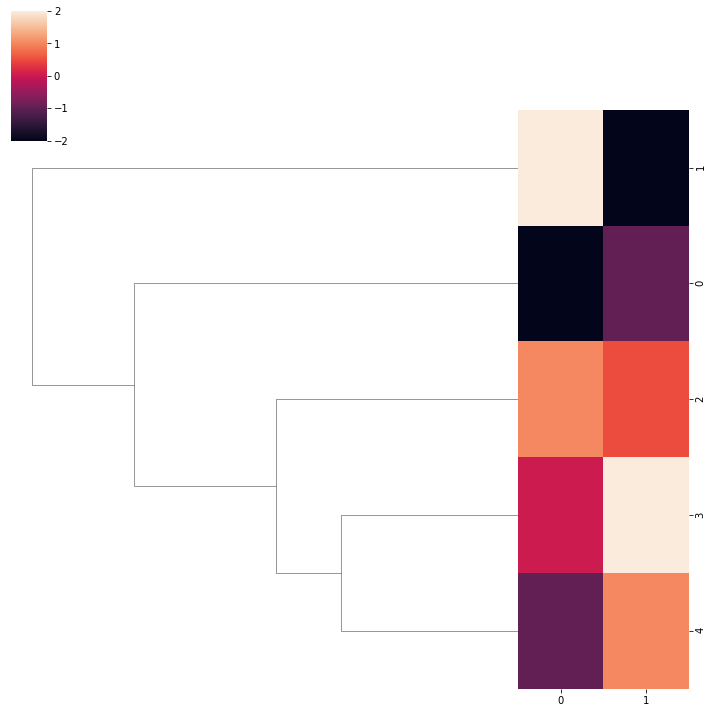

In [2]:
import seaborn as sns
sns.clustermap(X,col_cluster=False,dendrogram_ratio=(.75,.15));

The horizontal position in the dendrogram above indicates the linkage strength. Note on the right that the ordering of the samples has been changed (so that the lines won't cross each other). The two colored columns show a heatmap of the two features of the sample points. Working from right to left, we see the merger of samples 3 and 4, which are then merged with sample 2, etc. 

In effect, we get an entire family of clusterings by stopping at any linkage value we want. If we chose to stop at value 2.5, for instance, we would have two clusters of size 4 and 1. Or, if we predetermine that we want $k$ clusters, we can stop after $n-k$ merge steps.

## Test sets

We will use three test sets to illustrate the different linkages.

In [3]:
import pandas as pd
from sklearn.datasets import make_blobs
from numpy.random import default_rng
import matplotlib.pyplot as plt

X,y = make_blobs(
    n_samples=[60,50,40],
    centers=[[-2,3],[3.5,1.5],[1,-3]],
    cluster_std=[0.5,0.9,1.2],
    random_state = 19716
    )
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
x1x2 = ["x1","x2"]

rng = default_rng(6)
inner = 0.8*rng.normal(size=(100,2))
theta = rng.uniform(0,2*np.pi,size=200)
r = rng.uniform(3,4,size=200)
middle = np.vstack((r*np.cos(theta),r*np.sin(theta))).T
r = rng.uniform(5,6,size=200)
outer = np.vstack((r*np.cos(theta),r*np.sin(theta))).T
bullseye = pd.DataFrame(np.vstack((inner,middle,outer)),columns=x1x2)
bullseye["class"] = np.hstack(([0]*100,[1]*200,[2]*200))

rng = default_rng(9)
x1,x2,y = [],[],[]
for i in range(3):
    x1.extend(rng.uniform(-10,10,size=200))
    x2.extend(2.5*i+rng.uniform(0,1,size=200))
    y.extend([i]*200)
stripes = pd.DataFrame({"x1":x1,"x2":x2,"class":y})

In [4]:
from sklearn.cluster import AgglomerativeClustering

def run_experiment(frames,link):
    f,axes = plt.subplots(1,3,figsize=(14,8),subplot_kw=dict(aspect=1))
    agg = AgglomerativeClustering(n_clusters=3,linkage=link)
    for data,ax in zip(frames,axes):
        agg.fit(data[x1x2])
        data[link] = agg.labels_
        sns.scatterplot(data=data,x="x1",y="x2",hue=link,ax=ax);
    return f

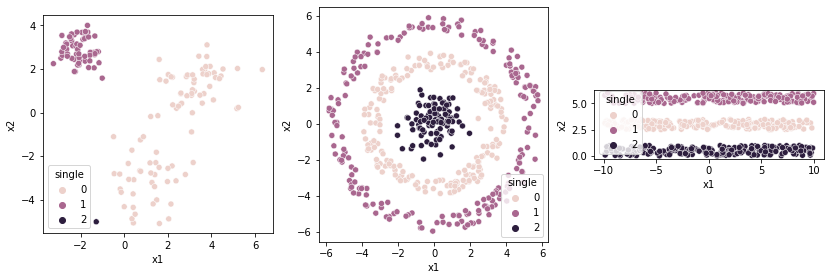

In [5]:
run_experiment([blobs,bullseye,stripes],"single");

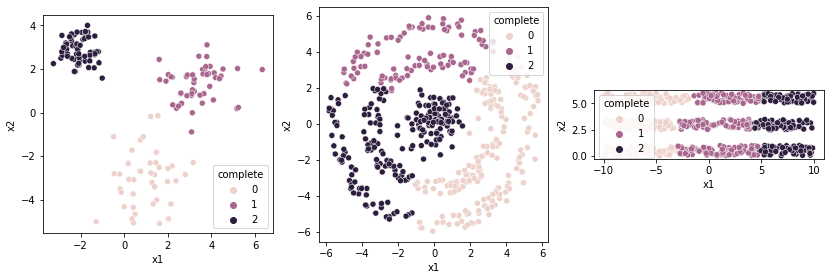

In [6]:
run_experiment([blobs,bullseye,stripes],"complete");

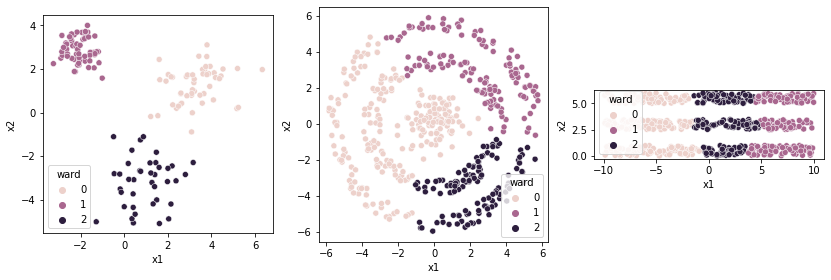

In [7]:
run_experiment([blobs,bullseye,stripes],"ward");

What stands out above is that single linkage has more geometric flexibility. This is helpful when the samples are grouped into well-separated clusters that are not necessarily compact and sphere-like. However, it can also be sensitive to individual samples. Here, we add just one point to the bullseye picture and get a big change:

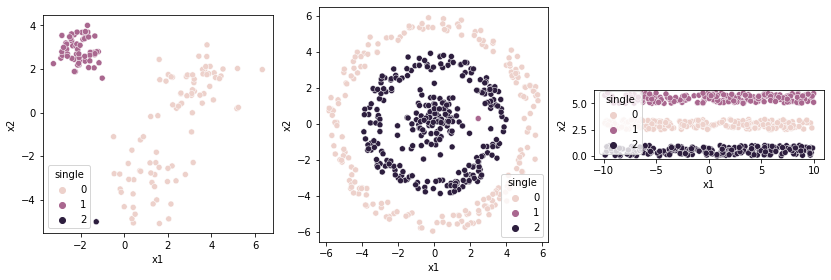

In [8]:
bullseye = pd.concat((bullseye,pd.DataFrame({"x1":[0],"x2":[2.25],"class":[0]})))
run_experiment([blobs,bullseye,stripes],"single");

The other linkages pay more attention to the compactness of the cluster shapes, which is much more limiting, but they are not as affected by small changes to the interior points.

 

## Case study: Penguins

Let's try agglomerative clustering to discover the species of the penguins. First, let's recall how many of each species we have.

In [9]:
penguins = sns.load_dataset("penguins").dropna()
X = penguins[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]]
print(penguins["species"].value_counts())

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64


Our first attempt is single linkage. Because 2-norm distances are involved, we will use standardization in a pipeline with the clustering method. After fitting, the `labels_` property of the cluster object is a vector of cluster assignments.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

single = AgglomerativeClustering(n_clusters=3,linkage="single")
pipe = make_pipeline(StandardScaler(),single)
pipe.fit(X)
penguins["single"] = single.labels_       # cluster assignments
penguins.loc[::24,["species","single"]]   # print out some rows

,species,single
0,Adelie,0
29,Adelie,0
54,Adelie,0
78,Adelie,0
102,Adelie,0
126,Adelie,0
150,Adelie,0
174,Chinstrap,0
198,Chinstrap,0
222,Gentoo,2


It seems that Gentoo is associated with cluster number 2, but the situation with the other species is less clear. Here are the value counts:

In [11]:
print("single linkage results:")
print(penguins["single"].value_counts())

single linkage results:
0    213
2    119
1      1
Name: single, dtype: int64


Comparing these with the species counts, it seems that the clustering may have found the Gentoo cases perfectly. That would imply that the other ones are almost all lumped into cluster 0, however. Here is the adjusted Rand index.

In [12]:
from sklearn.metrics import adjusted_rand_score
ARI = adjusted_rand_score(penguins["species"],penguins["single"])
print(f"single linkage ARI: {ARI:.4f}")

single linkage ARI: 0.6506


Now let's try it with Ward linkage (the default).

In [13]:
ward = AgglomerativeClustering(n_clusters=3,linkage="ward")
pipe = make_pipeline(StandardScaler(),ward)
pipe.fit(X)
penguins["ward"] = ward.labels_

print("Ward linkage results:")
print(penguins["ward"].value_counts())

Ward linkage results:
1    157
0    119
2     57
Name: ward, dtype: int64


This result looks more promising. The ARI confirms that hunch:

In [14]:
ARI = adjusted_rand_score(penguins["species"],penguins["ward"])
print(f"Ward linkage ARI: {ARI:.4f}")

Ward linkage ARI: 0.9132


If we guess at the likely correspondence between the cluster numbers and the different species, then we can find the confusion matrix:

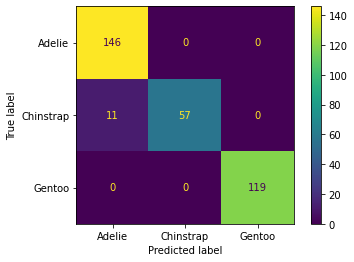

In [15]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y = penguins["species"]
# Convert cluster numbers into labels:
y_hat = penguins["ward"].replace({1:"Adelie",0:"Gentoo",2:"Chinstrap"}) 

ConfusionMatrixDisplay(confusion_matrix(y,y_hat),display_labels=y.unique()).plot();

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_1zv4cc9l&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_0wtxt9if" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>